## Annotate `'pediatric_dkfz_2017'` study's mutation endpoints from cBioPortal using OncoKB REST API.

First import `bravado` and `pandas`.

Initialize REST APIs for cBioPortal and OncoKB.

In [1]:
from bravado.client import SwaggerClient
from bravado.requests_client import RequestsClient
from bravado.swagger_model import load_file, Loader

from pprint import pprint
from copy import *

import matplotlib
import pandas

%matplotlib inline

plot_w, plot_h = matplotlib.rcParams['figure.figsize']

cbioportal = SwaggerClient.from_url('https://www.cbioportal.org/api/api-docs',
                                config={"validate_requests":False,"validate_responses":False})

# OncoKB swagger is generated separately from the main website, we need to manually change the host to www.oncokb.org 
oncokb_swagger_url='https://www.oncokb.org/api/v1/v2/api-docs?group=Public%20APIs'
http_client = RequestsClient()
loader = Loader(http_client)
spec_dict = loader.load_spec('https://www.oncokb.org/api/v1/v2/api-docs?group=Public%20APIs')
spec_dict['host'] = 'www.oncokb.org'
oncokb = SwaggerClient.from_spec(spec_dict,
                                config={"validate_requests":False,"validate_responses":False})

### Define method to run oncokb annotation in POST.
#### Please ask for the oncokb token if you don't have an account and update `oncokb_token` below

In [2]:
def make_oncokb_post_request(requests):
    oncokb_token=''
    oncokb_request_headers = {
      'Authorization': 'Bearer {}'.format(oncokb_token)
    }

    request_options = {
        # === bravado config ===
        'headers': oncokb_request_headers,
    }
    return json.loads(oncokb.Annotations.annotateMutationsByProteinChangePostUsingPOST_1(
            _request_options=request_options,
            body=requests
        ).response().result)

Define method to process mutations and get annotated

In [3]:
POST_LENGTH_THRESHOLD=1000
def annotate_mutations(mutations):
    msk_mutation_annotations = []
    requests = []
    sub_mutations = []
    for idx, m in enumerate(mutations):
        QueryGene = oncokb.get_model('QueryGene')
        AnnotateMutationByProteinChangeQuery = oncokb.get_model('AnnotateMutationByProteinChangeQuery')
        requests.append(
            AnnotateMutationByProteinChangeQuery(gene=QueryGene(entrezGeneId=m.entrezGeneId), alteration=m.proteinChange))
        sub_mutations.append(m)
        if len(requests) == POST_LENGTH_THRESHOLD:
            resp = make_oncokb_post_request(requests)
            msk_mutation_annotations.extend(zip(sub_mutations, resp))
            print('Annotated {}/{} mutations'.format(idx+1, len(mutations)))
            requests = []
            sub_mutations = []
    if (len(requests) > 0):
        resp = make_oncokb_post_request(requests)
        msk_mutation_annotations.extend(zip(sub_mutations, resp))
        requests = []
        sub_mutations = []
    return msk_mutation_annotations

Retrieve all available clinical data in `'pediatric_dkfz_2017'` study:

In [4]:
msk_clinical_data=cbioportal.Clinical_Data.getAllClinicalDataInStudyUsingGET(studyId='pediatric_dkfz_2017').result()

The clinical data returned from `getAllClinicalDataInStudyUsingGET()` can be inserted into a DataFrame.

In [5]:
%%time

parsed_clinical_data = dict()
for cd in msk_clinical_data:
    if cd.uniqueSampleKey not in parsed_clinical_data:
        parsed_clinical_data[cd.uniqueSampleKey] = dict()
        parsed_clinical_data[cd.uniqueSampleKey]['uniqueSampleKey'] = cd.uniqueSampleKey
        parsed_clinical_data[cd.uniqueSampleKey][cd.clinicalAttributeId] = cd.value
        parsed_clinical_data[cd.uniqueSampleKey]['patientId'] = cd.patientId
        parsed_clinical_data[cd.uniqueSampleKey]['sampleId'] = cd.sampleId
        parsed_clinical_data[cd.uniqueSampleKey]['studyId'] = cd.studyId
        parsed_clinical_data[cd.uniqueSampleKey]['uniquePatientKey'] = cd.uniquePatientKey
    else:
        parsed_clinical_data[cd.uniqueSampleKey][cd.clinicalAttributeId] = cd.value

cd_df = pandas.DataFrame.from_dict([cd[1] for cd in parsed_clinical_data.items()])

CPU times: user 99.4 ms, sys: 12.1 ms, total: 111 ms
Wall time: 128 ms


In [6]:
print("number of clinical data endpoints:", len(parsed_clinical_data))

number of clinical data endpoints: 961


Here, the study samples can be categorized under `'CANCER_TYPE'`.

In [7]:
msk_clinical_data_sorted_cancer_type = cd_df.groupby('CANCER_TYPE')['uniqueSampleKey'].nunique().sort_values(ascending=False)

Here is a plot of the studies' samples sorted by `'CANCER_TYPE'`:

<AxesSubplot:xlabel='CANCER_TYPE'>

/srv/conda/envs/notebook/lib_pypy/_functools.py:80: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  return self._func(*(self._args + fargs), **fkeywords)


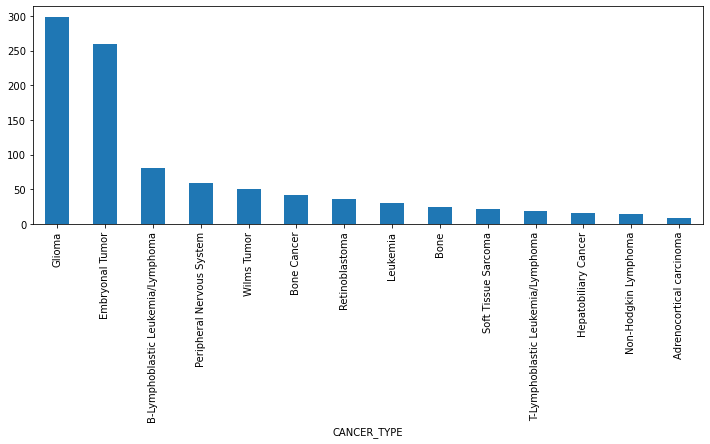

In [8]:
msk_clinical_data_sorted_cancer_type.plot(kind='bar', figsize=(2*plot_w, plot_h))

Obtain mutations for `'pediatric_dkfz_2017'`:

In [9]:
%%time

mutations = cbioportal.Mutations.getMutationsInMolecularProfileBySampleListIdUsingGET(
    molecularProfileId='pediatric_dkfz_2017_mutations',
    sampleListId='pediatric_dkfz_2017_all',
    projection='DETAILED'
).result()

CPU times: user 719 ms, sys: 37.7 ms, total: 757 ms
Wall time: 1.69 s


Combine `'pediatric_dkfz_2017'` clinical data endpoints with `'pediatric_dkfz_2017'` mutations endpoints.

Obtain the set of mutation entrez gene IDs (this makes it easier to count the total number of `entrezGeneId`s):

In [10]:
mutations_entrezGeneId = set()
for m in mutations:
    mutations_entrezGeneId.add(m.entrezGeneId)

print("There are {0} `'pediatric_dkfz_2017'` mutation entrez gene IDs!".format(len(mutations_entrezGeneId)))

There are 7181 `'pediatric_dkfz_2017'` mutation entrez gene IDs!


Use gene mutation ID and proteinChange to filter OncoKB's Annotations:

In [11]:
msk_cd_with_mutations = deepcopy(parsed_clinical_data)
for m in mutations:
    if 'mutations' not in msk_cd_with_mutations[m.uniqueSampleKey]:
        msk_cd_with_mutations[m.uniqueSampleKey]['mutations'] = []
    msk_cd_with_mutations[m.uniqueSampleKey]['mutations'].append(m)

print("There are {0} `'pediatric_dkfz_2017'` study samples without mutations.\n".format(len([kv[1] for kv in msk_cd_with_mutations.items() if ('mutations' not in kv[1])])))
print("Total number of mutations in `'pediatric_dkfz_2017'` study:", len(mutations))

There are 111 `'pediatric_dkfz_2017'` study samples without mutations.

Total number of mutations in `'pediatric_dkfz_2017'` study: 12127


## Requesting annotations for all `'pediatric_dkfz_2017'` study mutations (might take ~5 minutes)!

In [12]:
%%time

import json

msk_mutation_annotations = annotate_mutations(mutations)

assert len(msk_mutation_annotations) == len(mutations), "some annotation requests failed"

Annotated 1000/12127 mutations
Annotated 2000/12127 mutations
Annotated 3000/12127 mutations
Annotated 4000/12127 mutations
Annotated 5000/12127 mutations
Annotated 6000/12127 mutations
Annotated 7000/12127 mutations
Annotated 8000/12127 mutations
Annotated 9000/12127 mutations
Annotated 10000/12127 mutations
Annotated 11000/12127 mutations
Annotated 12000/12127 mutations
CPU times: user 950 ms, sys: 68.1 ms, total: 1.02 s
Wall time: 25.2 s


In [13]:
msk_mutation_annotations[0]

(Mutation(alleleSpecificCopyNumber=None, aminoAcidChange=None, center='.', chr='12', driverFilter=None, driverFilterAnnotation=None, driverTiersFilter=None, driverTiersFilterAnnotation=None, endPosition=25398284, entrezGeneId=3845, fisValue=1.4013e-45, functionalImpactScore='', gene=Gene(entrezGeneId=3845, geneticEntityId=None, hugoGeneSymbol='KRAS', type='protein-coding'), keyword='KRAS G12 missense', linkMsa='', linkPdb='', linkXvar='', molecularProfileId='pediatric_dkfz_2017_mutations', mutationStatus='NA', mutationType='Missense_Mutation', namespaceColumns=None, ncbiBuild='GRCh37', normalAltCount=None, normalRefCount=None, patientId='ALL-B-2', proteinChange='G12V', proteinPosEnd=12, proteinPosStart=12, referenceAllele='C', refseqMrnaId='NM_033360.2', sampleId='ALL-B-2', startPosition=25398284, studyId='pediatric_dkfz_2017', tumorAltCount=None, tumorRefCount=None, uniquePatientKey='QUxMLUItMjpwZWRpYXRyaWNfZGtmel8yMDE3', uniqueSampleKey='QUxMLUItMjpwZWRpYXRyaWNfZGtmel8yMDE3', validat

In [60]:
msk_annotated_mutation_cancer_types = [
    {**{'oncogenic': m[1]['oncogenic'], 'uniquePatientKey': m[0]['uniquePatientKey'],'CANCER_TYPE': parsed_clinical_data[m[0].uniqueSampleKey]['CANCER_TYPE']}}
    for m in msk_mutation_annotations]

In [61]:
len(msk_annotated_mutation_cancer_types)

12127

In [62]:
msk_annotated_mutation_cancer_types[0]

{'oncogenic': 'Oncogenic',
 'uniquePatientKey': 'QUxMLUItMjpwZWRpYXRyaWNfZGtmel8yMDE3',
 'CANCER_TYPE': 'B-Lymphoblastic Leukemia/Lymphoma'}

In [63]:
msk_annotated_mutation_cancer_types_driver=[am for am in msk_annotated_mutation_cancer_types if am['oncogenic'] == 'Oncogenic' or am['oncogenic'] == 'Likely Oncogenic' or am['oncogenic'] == 'Predicted Oncogenic']





In [64]:
len(msk_annotated_mutation_cancer_types_driver)

654

In [65]:
msk_annotated_mutation_cancer_types_driver[0]

{'oncogenic': 'Oncogenic',
 'uniquePatientKey': 'QUxMLUItMjpwZWRpYXRyaWNfZGtmel8yMDE3',
 'CANCER_TYPE': 'B-Lymphoblastic Leukemia/Lymphoma'}

In [68]:
df = pandas.DataFrame.from_dict(msk_annotated_mutation_cancer_types_driver)

In [69]:
result = {}
for idx, group in df.groupby(["CANCER_TYPE","uniquePatientKey"]):
    cancer_type, key = idx
    if cancer_type not in result:
        result[cancer_type] = []
    result[cancer_type].append(len(group))
    
data = []
columns = []
for idx, data1 in result.items():
    columns.append(idx)
    data.append(data1)

In [70]:
print(data)

[[1, 1, 2, 2, 1], [1, 1, 3, 2, 3, 1, 1, 3, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 3, 1, 2, 1, 2, 1, 1, 2, 1], [1, 1, 1, 1, 1, 1, 2, 1], [2, 1, 1, 1, 2, 1, 1, 1], [1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 3, 1, 1, 1, 2, 5, 2, 2, 1, 4, 2, 2, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 3, 1, 2, 1, 1, 1, 1, 2, 1, 4, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 3, 1, 2, 2, 3, 2, 3, 1, 2, 2, 4, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 2], [1, 1, 1, 2, 1, 2, 4, 2, 3, 2, 2, 3, 11, 4, 2, 2, 5, 2, 4, 4, 3, 7, 4, 9, 3, 3, 3, 2, 3, 3, 2, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 1, 2, 3, 1, 2, 3, 2, 1, 3, 1, 2, 2, 4, 1, 1, 1, 3, 1, 1, 3, 3, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 3, 2, 2, 4, 2, 1, 2, 1, 2, 3, 3, 2, 2, 1, 1, 4, 1, 2, 2, 3, 3, 4, 1, 4, 2], [1, 2, 2, 1], [1, 3, 6, 1, 1, 2, 1, 1, 2, 3, 2, 1, 1, 1, 4, 1, 1], [3, 4, 5, 7, 8, 2, 5, 6, 6, 5, 5, 3, 3], [1, 1, 1, 1, 1, 1, 2, 1], [1, 2, 1, 1, 1, 2, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1], [1, 2, 1, 1, 2, 2, 2, 

In [71]:
reverted_df = pandas.DataFrame(data).T

In [72]:
reverted_df.columns=columns

In [73]:
meds = reverted_df.median()

In [74]:
print(meds)

Adrenocortical carcinoma             1.0
B-Lymphoblastic Leukemia/Lymphoma    1.0
Bone                                 1.0
Bone Cancer                          1.0
Embryonal Tumor                      1.0
Glioma                               2.0
Hepatobiliary Cancer                 1.5
Leukemia                             1.0
Non-Hodgkin Lymphoma                 5.0
Peripheral Nervous System            1.0
Retinoblastoma                       1.0
Soft Tissue Sarcoma                  1.5
T-Lymphoblastic Leukemia/Lymphoma    1.5
Wilms Tumor                          1.0
dtype: float64


In [75]:

meds.sort_values(ascending=False, inplace=True)
reverted_df = reverted_df[meds.index]

<AxesSubplot:>

/srv/conda/envs/notebook/lib_pypy/_functools.py:80: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  return self._func(*(self._args + fargs), **fkeywords)


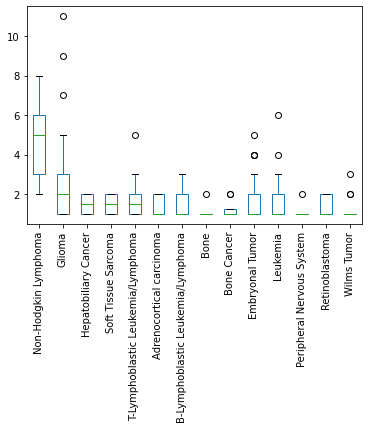

In [76]:
reverted_df.plot.box(rot=90)

In [33]:
result = []
for idx, group in df.groupby("CANCER_TYPE"):
    sample numbers
    for idx1, group1 in group.groupby("uniquePatientKey")
    
    
    result.append((idx, len()))
#     print(idx)
#     print(len(group))
#     display(group)
#     break
print(columns)

{'Adrenocortical carcinoma', 'B-Lymphoblastic Leukemia/Lymphoma', 'Bone', 'Bone Cancer', 'Embryonal Tumor', 'Glioma', 'Hepatobiliary Cancer', 'Leukemia', 'Non-Hodgkin Lymphoma', 'Peripheral Nervous System', 'Retinoblastoma', 'Soft Tissue Sarcoma', 'T-Lymphoblastic Leukemia/Lymphoma', 'Wilms Tumor'}


Filter `'pediatric_dkfz_2017'` study mutations by `'LEVEL_1'`:

In [ ]:
msk_annotated_mutation_cancer_types[0]

In [ ]:
msk_annotated_mutation_cancer_types_level_1 = [am for am in msk_annotated_mutation_cancer_types if am['highestSensitiveLevel'] == 'LEVEL_1']
annotations_level_1_df = pandas.DataFrame.from_dict(msk_annotated_mutation_cancer_types_level_1)
annotations_level_1_df.groupby('CANCER_TYPE')['uniqueSampleKey'].nunique().sort_values(ascending=False).plot(kind='bar', figsize=(2*plot_w, plot_h), color='#33A02C').set_title('LEVEL_1', fontsize=14)

Filter `'pediatric_dkfz_2017'` study mutations by `'LEVEL_2'`:

In [ ]:
msk_annotated_mutation_cancer_types_level_2 = [am for am in msk_annotated_mutation_cancer_types if am['highestSensitiveLevel'] == 'LEVEL_2']

annotations_level_2_df = pandas.DataFrame.from_dict(msk_annotated_mutation_cancer_types_level_2)
if not annotations_level_2_df.empty:
    annotations_level_2_df.groupby('CANCER_TYPE')['uniqueSampleKey'].nunique().sort_values(ascending=False).plot(kind='bar', figsize=(2*plot_w, plot_h), color='#1F78B4').set_title('LEVEL_2', fontsize=14)


Filter `'pediatric_dkfz_2017'` study mutations by `'VUS'`:

In [ ]:
msk_annotated_mutation_cancer_types_vus = [am for am in msk_annotated_mutation_cancer_types if ((not (am['vus'] is None)) and am['vus'])]

annotations_vus_df = pandas.DataFrame.from_dict(msk_annotated_mutation_cancer_types_vus)
if not annotations_vus_df.empty:
    annotations_vus_df.groupby('CANCER_TYPE')['uniqueSampleKey'].nunique().sort_values(ascending=False).plot(kind='bar', figsize=(2*plot_w, plot_h), color='#d1d1d1').set_title('VUS', fontsize=14)


## Requesting annotations for only `'Non-Small Cell Lung Cancer'` mutations in `'pediatric_dkfz_2017'`.

In [ ]:
msk_clinical_data_nsclc = [kv[1] for kv in msk_cd_with_mutations.items() if (kv[1]['CANCER_TYPE'] == 'Non-Small Cell Lung Cancer')]
msk_clinical_data_nsclc_set = set()
for cd_nsclc in msk_clinical_data_nsclc:
    if 'mutations' in cd_nsclc:
        for m in cd_nsclc['mutations']:
            msk_clinical_data_nsclc_set.add((m.entrezGeneId, m.proteinChange))
print("Total number of `'Non-Small Cell Lung Cancer'` mutations in `'pediatric_dkfz_2017'` study:", len(msk_clinical_data_nsclc_set))

In [ ]:
msk_clinical_data_nsclc[0]

In [ ]:

msk_clinical_data_nsclc_dict = []
for set_item in msk_clinical_data_nsclc_set:
    Mutation = cbioportal.get_model('Mutation')
    msk_clinical_data_nsclc_dict.append(Mutation(entrezGeneId=set_item[0], proteinChange=set_item[1]))

The requests may take ~1 minute.

In [ ]:
%%time

msk_clinical_data_nsclc_annotations = annotate_mutations(msk_clinical_data_nsclc_dict)


In [ ]:
msk_clinical_data_nsclc_annotations[0]

In [ ]:
msk_nsclc_annotated_mutation_cancer_types = [
    {**m[0]._Model__dict,
    **m[1]}
    for m in msk_clinical_data_nsclc_annotations]

In [ ]:
msk_nsclc_annotated_mutation_cancer_types[0]

In [ ]:
[nsclc_annotation['highestSensitiveLevel'] for nsclc_annotation in msk_nsclc_annotated_mutation_cancer_types]
set([nsclc_annotation['vus'] for nsclc_annotation in msk_nsclc_annotated_mutation_cancer_types])
set([nsclc_annotation['oncogenic'] for nsclc_annotation in msk_nsclc_annotated_mutation_cancer_types])
set([nsclc_annotation['highestSensitiveLevel'] for nsclc_annotation in msk_nsclc_annotated_mutation_cancer_types])


In [ ]:
msk_clinical_data_nsclc_level = dict()
for nsclc_annotation in msk_nsclc_annotated_mutation_cancer_types:
    if not (nsclc_annotation['highestSensitiveLevel'] is None):
        if nsclc_annotation['highestSensitiveLevel'] not in msk_clinical_data_nsclc_level:
            msk_clinical_data_nsclc_level[nsclc_annotation['highestSensitiveLevel']] = 1
        else:
            msk_clinical_data_nsclc_level[nsclc_annotation['highestSensitiveLevel']] += 1
    elif (not (nsclc_annotation['vus'] is None)) and nsclc_annotation['vus']:
        if 'VUS' not in msk_clinical_data_nsclc_level:
            msk_clinical_data_nsclc_level['VUS'] = 1
        else:
            msk_clinical_data_nsclc_level['VUS'] += 1
    elif (nsclc_annotation['oncogenic'] == 'Oncogenic'
            or nsclc_annotation['oncogenic'] == 'Likely Oncogenic'
            or nsclc_annotation['oncogenic'] == 'Predicted Oncogenic'):
        if 'Oncogenic, no level' not in msk_clinical_data_nsclc_level:
            msk_clinical_data_nsclc_level['ONCOGENIC'] = 1
        else:
            msk_clinical_data_nsclc_level['ONCOGENIC'] += 1
    elif (nsclc_annotation['oncogenic'] == 'Likely Neutral' or nsclc_annotation['oncogenic'] == 'Inconclusive'):
        if 'Other' not in msk_clinical_data_nsclc_level:
            msk_clinical_data_nsclc_level['Other'] = 1
        else:
            msk_clinical_data_nsclc_level['Other'] += 1
    elif nsclc_annotation['alleleExist'] is False:
        if 'Other' not in msk_clinical_data_nsclc_level:
            msk_clinical_data_nsclc_level['Other'] = 1
        else:
            msk_clinical_data_nsclc_level['Other'] += 1
    elif nsclc_annotation['variantExist'] is False:
        if 'Other' not in msk_clinical_data_nsclc_level:
            msk_clinical_data_nsclc_level['Other'] = 1
        else:
            msk_clinical_data_nsclc_level['Other'] += 1
    elif nsclc_annotation['geneSummary'] == '':
        if 'Other' not in msk_clinical_data_nsclc_level:
            msk_clinical_data_nsclc_level['Other'] = 1
        else:
            msk_clinical_data_nsclc_level['Other'] += 1
    else:
        assert False, print(nsclc_annotation)


In [ ]:
msk_clinical_data_nsclc_level

In [ ]:
oncokb_level_colors = {
    'LEVEL_1': '#33A02C',
    'LEVEL_2': '#1F78B4',
    'LEVEL_3A': '#984EA3',
    'LEVEL_3B': '#BE98CE',
    'LEVEL_4': '#a8a8a8',
    'LEVEL_R1': '#EE3424',
    'LEVEL_R2': '#F79A92',
    'LEVEL_R3': '#FCD6D3',
    'ONCOGENIC': '#ffdab9',
    'VUS': '#d1d1d1',
    'Other': 'grey'
}

cd_nsclc_level_index = []
cd_nsclc_level_colors = []
cd_nsclc_level = dict()
cd_nsclc_level['Non-Small Cell Lung Cancer'] = []

for i in msk_clinical_data_nsclc_level.items():
    cd_nsclc_level_colors.append(oncokb_level_colors[i[0]])
    cd_nsclc_level_index.append(i[0])
    cd_nsclc_level['Non-Small Cell Lung Cancer'].append(i[1])

cd_nsclc_df = pandas.DataFrame(cd_nsclc_level, index=cd_nsclc_level_index)
cd_nsclc_df.plot.pie(y='Non-Small Cell Lung Cancer', figsize=(2*plot_w, 2*plot_w), colors=cd_nsclc_level_colors)